In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 파일 불러오기
df = pd.read_csv('./KODEX200_220624_20220726.csv', encoding='cp949')
#'일자'를 datetime 객체로 설정 
df = df.set_index('일자')

# 최종 데이터프레임의 이름은 'df' 
df = df.drop(columns=['시가','고가','저가','대비','등락률','순자산가치(NAV)','거래대금','시가총액','순자산총액','상장좌수','기초지수_지수명','기초지수_종가','기초지수_대비','기초지수_등락률','거래량'], axis=1)
df

## 훈련데이터 테스트데이터 분리

<a href="https://todayisbetterthanyesterday.tistory.com/67"> plot함수 그리기</a>

In [16]:
# 한글 폰트 사용을 위해 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/H2GTRM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family = font)

Text(0, 0.5, '종가')

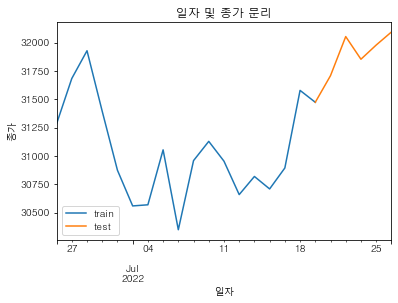

In [18]:
# '07-19-2022'기준으로 데이터를 분리한다.
split_date = pd.Timestamp('07-19-2022')

# df의 ':split_date'를 기준으로 '종가'변수만 가져오는 것
# Train Data
X_train = df.loc[:split_date,['종가']]
X_test = df.loc[split_date:, ['종가']]

# Test Data
y_train = df.loc[:split_date,['종가']]
y_test = df.loc[split_date:, ['종가']]

# 함수 그래프 그리기
ax = X_train.plot()
X_test.plot(ax=ax)
plt.legend(['train','test'])
# xlabel과 ylabel값 입력
plt.title('일자 및 종가 분리')
plt.xlabel('일자')
plt.ylabel('종가')

## 데이터 전처리

In [20]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
# 스케일을 적용할 column을 정의
scale_cols = ['종가']
# 스케일 후 columns
train_sc = sc.fit_transform(X_train)
test_sc = sc.transform(X_test)

train_sc

array([[0.59177215],
       [0.84493671],
       [1.        ],
       [0.66139241],
       [0.33227848],
       [0.13291139],
       [0.13924051],
       [0.44620253],
       [0.        ],
       [0.38607595],
       [0.49367089],
       [0.38291139],
       [0.19620253],
       [0.29746835],
       [0.2278481 ],
       [0.34493671],
       [0.77848101],
       [0.71202532]])

In [24]:
"""
torch Variable에는 3개의 형태가 있다. 
data, grad, grad_fn 한 번 구글에 찾아서 공부해보길 바랍니다. 
"""
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

ValueError: could not determine the shape of object type 'DataFrame'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
print(torch.cuda.get_device_name(0))

In [27]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

In [28]:
num_epochs = 30000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [29]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

NameError: name 'X_train_tensors_final' is not defined

In [ ]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors.to(device))

  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
출처: https://coding-yoon.tistory.com/131 [코딩도상국:티스토리]

In [ ]:
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:, 5:6])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
출처: https://coding-yoon.tistory.com/131 [코딩도상국:티스토리]

In [ ]:
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 
출처: https://coding-yoon.tistory.com/131 [코딩도상국:티스토리]